# First Look at Imaging
*Modular CASA and Interactive Clean*

This guide is written for CASA x.x.x.x and uses Python 3.

The purpose of this tutorial is to provide a first look at imaging ALMA data for those new to CASA.

Data delivered by ALMA is pre-calibrated either by ARC staff or by the ALMA calibration pipeline. The delivered data is ready for imaging. This tutorial demonstrates the basic procedures that will help you complete the imaging steps.

This guide covers the same material used in hands-on training sessions at [NRAO Community Days events](https://science.nrao.edu/facilities/alma/naasc-workshops/facilities/alma/community) and ALMA Data Reduction tutorials presented by NAASC staff.

Previous versions of "Imaging Tutorials for CASA Beginners" guides can be found [here](https://casaguides.nrao.edu/index.php?title=Archived_ALMA_CASAguides). The task tclean is only available in CASA 4.7 and later, and interactive clean is only available in CASA X.X and later.

## Getting CASA

If you do not already have the needed CASA Python packages installed on your machine, you will have to download and install it. We recommend using a Python `venv` for this tutorial. For this tutorial, with modular CASA, installation is as easy as a few pip installs.

Alternative CASA download and installation instructions are available [here](http://casa.nrao.edu/casa_obtaining.shtml).

### Create a virtual environment with Python3.8
```python3.8 -m venv first_look_venv```

### Activate the virtual environment
```source first_look_venv/bin/activate```

### Download necessary packages
```pip3 install jupyter casagui casatasks```


## Import the Needed Packages

In [1]:
import os
import sys

from bokeh.plotting import output_notebook
from bokeh.io import show
from bokeh.models import Title
from bokeh.layouts import row, column

import casatasks
from casagui.apps import InteractiveClean, MakeMask
output_notebook()

Loading BokehJS ...

Loading BokehJS ...

### Display Helper function

In [13]:
def disp(image_path, title):
    im = MakeMask(image_path)
    im._cube.image().add_layout(Title(text=title, align="center"), "above")
    return im._cube.image()

## About the Sample Data: Continuum and N2H+ in TW Hydra

The data for this example comes from ALMA Project 2011.0.00340.S, "Searching for H2D+ in the disk of TW Hya v1.5", for which the PI is Chunhua Qi. Part of the data for this project has been published in [Qi et al. 2013](http://adsabs.harvard.edu/abs/2013Sci...341..630Q).

The original observation had three scientific objectives:

1. Image the submm continuum structure in TW Hydra
2. Image the H2D+ line structure (rest frequency 372.42138 GHz)
3. Image the N2H+ line structure (rest frequency 372.67249 GHz)

The data used in our tutorial has already been calibrated. Furthermore, to make the data set more manageable, we have reduced it in size by averaging in time and frequency. Our goal will be to image the continuum emission and the N2H+ spectral line, which is bright and well suited for demonstrating the imaging techniques.

The spectral window we will image covers 234.375 MHz in bandwidth, and contains 384 channels spaced by 610 kHz. The data includes observations from 21 of the ALMA 12-m main array antennas, observed during Early Science Cycle 0.



## Getting the Data

The data used in this tutorial is part of a larger data package used for NRAO calibration and imaging tutorials. If you plan on working through all of the "First Look" tutorials for CASA beginners, it is worth downloading the entire package now. If you plan on working through just this imaging tutorial then you can download a smaller data package (see below).

The complete package (4.1G) is available here:

https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya.tgz

You can then unpack the data as follows:

In [14]:
!rm -rf MyTutorial
!mkdir MyTutorial
%cd MyTutorial

In [15]:
!tar -xvzf sis14_twhya.tar.gz

Alternatively, if you do not want to download the full 4.1G data package, you can download just the smaller data file (600M) needed specifically for this tutorial as follows:

In [16]:
!wget -r -np -nH --cut-dirs=4 --reject "index.html*" https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar
!tar -xf sis14_twhya_calibrated_flagged.ms.tar

--2023-05-08 15:58:48--  https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar
Resolving bulk.cv.nrao.edu (bulk.cv.nrao.edu)... 192.33.115.159
Connecting to bulk.cv.nrao.edu (bulk.cv.nrao.edu)|192.33.115.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 545730560 (520M) [application/x-tar]
Saving to: ‘sis14_twhya_calibrated_flagged.ms.tar’

100%[======================================>] 545,730,560  109MB/s   in 4.8s   

2023-05-08 15:58:53 (107 MB/s) - ‘sis14_twhya_calibrated_flagged.ms.tar’ saved [545730560/545730560]

FINISHED --2023-05-08 15:58:53--
Total wall clock time: 5.0s
Downloaded: 1 files, 520M in 4.8s (107 MB/s)


Or you can download the file via your browser at the following links: https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar

## Starting CASA

At this point you should be working in a unix shell from the directory that contains the data. An "ls" command should show you the data file "sis14_twhya_calibrated_flagged.ms" in the current working directory.

In [17]:
pwd

In [18]:
!ls

sis14_twhya_calibrated_flagged.ms  sis14_twhya_calibrated_flagged.ms.tar


Rather than using monolithic CASA like the previous tutorials, we will use a selection of its components and tools. 

## Getting Oriented with the Data

Let's examine the header information and data structure of our downloaded data set using [listobs](https://casa.nrao.edu/casadocs/latest/global-task-list/task_listobs/about). In the modular version of CASA, this is found under the `casatasks` package.

In [19]:
casatasks.listobs(vis='sis14_twhya_calibrated_flagged.ms')

{'BeginTime': 56250.31732611111,
 'EndTime': 56250.38269277778,
 'IntegrationTime': 5647.680000305176,
 'field_0': {'code': 'none',
  'direction': {'m0': {'unit': 'rad', 'value': 1.4092068104521434},
   'm1': {'unit': 'rad', 'value': -0.6363220835781705},
   'refer': 'J2000',
   'type': 'direction'},
  'name': 'J0522-364'},
 'field_2': {'code': 'none',
  'direction': {'m0': {'unit': 'rad', 'value': 1.6155895177294075},
   'm1': {'unit': 'rad', 'value': 0.40785875306878394},
   'refer': 'J2000',
   'type': 'direction'},
  'name': 'Ceres'},
 'field_3': {'code': 'none',
  'direction': {'m0': {'unit': 'rad', 'value': 2.780606185201184},
   'm1': {'unit': 'rad', 'value': -0.5160493207575416},
   'refer': 'J2000',
   'type': 'direction'},
  'name': 'J1037-295'},
 'field_5': {'code': 'none',
  'direction': {'m0': {'unit': 'rad', 'value': 2.887923300334642},
   'm1': {'unit': 'rad', 'value': -0.6057134431858937},
   'refer': 'J2000',
   'type': 'direction'},
  'name': 'TW Hya'},
 'field_6': {'

## Inspecting the Data

There are various ways we can inspect the data before cleaning it.

We can plot the antenna array layout for this observation with the `plotants` CASA task.

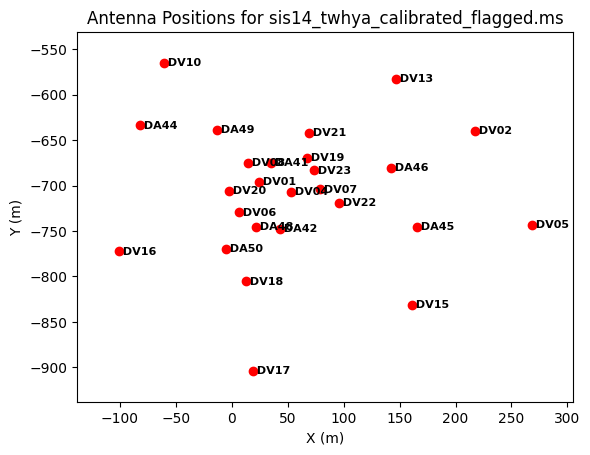

In [20]:
casatasks.plotants(vis='sis14_twhya_calibrated_flagged.ms/')

We can also view some of the statistics of the measurement set directly with `visstat`.

In [21]:
casatasks.visstat(vis='sis14_twhya_calibrated_flagged.ms/')

{'DATA_DESC_ID=0': {'firstquartile': 5.549664497375488,
  'isMasked': True,
  'isWeighted': False,
  'max': 135.49337768554688,
  'maxDatasetIndex': 368,
  'maxIndex': 30622,
  'mean': 10.068446212599525,
  'medabsdevmed': 3.6973180770874023,
  'median': 8.914886474609375,
  'min': 1.8359693854108627e-07,
  'minDatasetIndex': 36,
  'minIndex': 123917,
  'npts': 61826784.0,
  'rms': 12.01130421533607,
  'stddev': 6.54964277736687,
  'sum': 622499649.2020178,
  'sumOfWeights': 61826784.0,
  'sumsq': 8919838475.270119,
  'thirdquartile': 13.116724967956543,
  'variance': 42.897820511114006}}

## First Look at TCLEAN

Before we use interactive clean, let's first look tclean (which interactive clean provides an interactive user interface to).

Starting with CASA 4.7, the imaging capabilities of [clean](https://casa.nrao.edu/casadocs/latest/global-task-list/task_clean/about) have been refactored and improved in a task called [tclean](https://casa.nrao.edu/casadocs/latest/global-task-list/task_tclean/about), which is called by the user in largely the same way as clean. In the guide [TCLEAN and ALMA](https://casaguides.nrao.edu/index.php?title=TCLEAN_and_ALMA), the differences in syntax between clean and tclean are made more explicit. For reference, legacy first look guides for older versions of CASA that use clean rather than tclean or interactive clean for imaging are kept in [Archived ALMA CASAguides](https://casaguides.nrao.edu/index.php?title=Archived_ALMA_CASAguides).

In this dataset, the phase calibrator is identified by field 3. Let's image this calibrator into an image file called "phase_cal". First, in case you've run this task before, let's remove old versions of the image that use this name. (The ".*" is needed because imaging produces several files with the same root name).

In [22]:
!rm -rf phase_cal.*

Now we will use the task tclean to do the imaging. Here is an explanation of how we set some of the parameters; see the documentation for a complete list of tclean options.

- We will first image the phase calibrator, and set the image name to "phase_cal". To identify the phase calibrator in a measurement set, look at the 'ScanIntent' column in the output of listobs. The phase calibrator should have the intent "CALIBRATE_PHASE#ON_SOURCE". In this MS, the phase calibrator is J1037-295, identified by field = "3".

- We will use multifrequency synthesis (specmode = mfs) to make a single continuum image. Multifrequency synthesis combines data from all selected spectral channels into a single continuum image. If your observations cover a large frequency range, it is possible that the amplitude or structure of the source can change substantially with frequency. This is only a concern if the fractional bandwidth (delta_nu/nu_center) is greater than 10%. For this dataset it is not an issue. Therefore, we set deconvolver=hogbom, which uses nterms=1, telling tclean that each deconvolved component has a single amplitude at all frequencies.

- We will image a single pointing, so we set gridder='standard'. If we had multiple, contiguous pointings-- or if we were simultaneously imaging 7m and 12m array data (even if only a single pointing of each)--- we would need to set gridder='mosaic'.

- We set the cell size to 0.1 arcseconds, which places ~5 pixels across a beam. As a rule of thumb, we'd like ~5 pixels across the smallest direction of our elliptical beam. For a small dataset, you may be able to determine a good cell size with a quick imaging call, and note the beam calculated by tclean. For many ALMA projects, however, this could take a substantial amount of time! You can estimate what the cell size should be by looking again at the uv-coverage. Change the x-axis to uvwave, and the cell size is roughly 206265/(longest baseline in wavelengths)/(number of cells across the beam). For this MS, this works out to 0.09", which we round up to 0.1". As you will see, tclean reports a synthesized beam size of 0.58" x 0.51", making this choice just right.


- We set the image size to 128x128 (but note that factors of 2 are not magic for CASA). This is enough to cover most of the primary beam at the observing frequency, but we might want to image a wider field for a non-point source. Image sizes can be arbitrary but should be symmetrical. Good practice is probably to round up to the nearest 10 or 100 pixels and if tclean does not like your choice, it will recommend in the logger window a better choice.

Here, the tclean task will *NOT* run in interactive mode. For users familiar with clean, note that in contrast with the clean task, leaving niter (the maximum number of iterations) unset defaults to niter=0, and tclean is being told not to do any cleaning. If there are no clean components in the model -- for instance if this is the first invocation of tclean on this field and spectral window for the given set of visibilities (MS) -- then what will be created is the dirty cube or image. Here, we first run tclean with niter unset.

`tclean` is again found under the `casatasks` package.

In [23]:
casatasks.tclean(vis='sis14_twhya_calibrated_flagged.ms',
       imagename='phase_cal',
       field='3',
       spw='',
       specmode='mfs',
       deconvolver='hogbom',
       gridder='standard',
       imsize=[128,128],
       cell=['0.1arcsec'],
       weighting='briggs',
       threshold='0.0mJy')

2023-05-08 19:59:26	WARN	task_tclean::SIImageStore::restore (file src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2247)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


{}

Let's look at the generated dirty image:

In [24]:
im_dirty = disp('phase_cal.image', "Dirty Image")
show(im_dirty)

## Actual TCLEAN Run

Next, we'll actually run tclean on the image in non-interactive mode. This non-interactive mode can save you a lot of time and has the advantage of being very reproducible. Note, however, that best practice for an image with uncertain calibration and especially one with a bright source, is to clean interactively at least the first time. In the case where an image may be "dynamic range limited" (i.e., the quality is set by the accuracy of calibration and deconvolution) it can be hard to predict the correct threshold.

For non-interactive tclean, the three main parameters to specify are the threshold at which to stop (when the maximum residual in the tclean region is lower than this threshold, tclean stops), the mask (the region in which tclean is willing to identify signal), and the maximum number of iterations. The max iterations is not strictly required and it is generally recommended that it be used as more of a failsafe. That is, set it to a number so high that if tclean gets there something has gone wrong.

First let's take a stab at determining a clean mask. Look at the image you just made. All of the obvious emission is contained in a box that is bounded by pixel numbers in a range of something like (60,60) to (70,70). We'll set that box to be a mask using the "mask" parameter in the call to tclean. You could also set it by supplying a file (for example, one created from an earlier interactive version of tclean).

Now let's determine a stopping threshold for tclean. A clean threshold several times the rms noise is usually recommended to avoid adding false sources to the deconvolved image. For this tutorial, let's set the threshold to 7mJy (a number determined by doubling the RMS noise of an off-source region of the image). That is, you do not want tclean to treat a random noise spike as a source and deconvolve it from the image. This can be particularly problematic if you are doing self-calibration (a later lesson). Finally set niter=10000, which is a lot of iterations. We expect tclean to terminate before reaching this. For our purposes this is just a big number that's designed to keep tclean from running forever.

Run the command again, this time with niter set to some (large) number:

In [25]:
!rm -rf phase_cal.*

In [26]:
casatasks.tclean(vis='sis14_twhya_calibrated_flagged.ms',
       imagename='phase_cal',
       field='3',
       spw='',
       specmode='mfs',
       gridder='standard',
       deconvolver='hogbom',
       imsize=[128,128],
       cell=['0.1arcsec'],
       mask='box [ [ 60pix , 60pix] , [70pix, 70pix ] ]',
       weighting='briggs',
       threshold='0mJy',
       niter=10000)

{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 10000,
 'cyclethreshold': 2.877866972994525e-05,
 'interactiveiterdone': 10878,
 'interactivemode': False,
 'interactiveniter': 0,
 'interactivethreshold': 0.0,
 'iterdone': 10878,
 'loopgain': 0.10000000149011612,
 'maxpsffraction': 0.800000011920929,
 'maxpsfsidelobe': 0.1849374771118164,
 'minpsffraction': 0.05000000074505806,
 'niter': 10000,
 'nmajordone': 6,
 'nsigma': 0.0,
 'stopcode': 1,
 'summarymajor': array([    0,    17,    34,   140,   878, 10878]),
 'summaryminor': {0: {0: {0: {'iterDone': [17.0, 17.0, 106.0, 738.0, 10000.0],
     'peakRes': [0.09534332156181335,
      0.015900462865829468,
      0.0029134154319763184,
      0.0005368315614759922,
      0.00015567523951176554],
     'modelFlux': [0.47635596990585327,
      0.5557981729507446,
      0.5263646245002747,
      0.510305643081665,
      0.5025028586387634],
     'cycleThresh': [0.1057286337018013,
      0.01763242296874523,
    

In [27]:
im_simple_clean = disp('phase_cal.image', "Simple Clean Image")
im_simple_clean_mask = disp('phase_cal.mask', "Simple Clean Mask")
show(row(im_simple_clean, im_simple_clean_mask))

Compared to the dirty image, we're already seeing some good improvement!

In [28]:
show(row(im_dirty, im_simple_clean))

In [29]:
!ls

phase_cal.image  phase_cal.pb	     phase_cal.sumwt
phase_cal.mask	 phase_cal.psf	     sis14_twhya_calibrated_flagged.ms
phase_cal.model  phase_cal.residual  sis14_twhya_calibrated_flagged.ms.tar


All the resulting files have the "phase_cal" prefix, with different extensions:

.image is the final cleaned image
.mask shows the clean mask, or the area that tclean cleaned
.model is the set of modeled clean components used by tclean (in Jy/pixel)
.pb shows the primary beam response
.residual shows what was left after you stopped tclean (the "dirty" part of the final image)
.psf shows the synthesized beam
.sumwt is a single pixel image containing sum of weights per plane

So much good stuff. You can look at all of these using the CASA viewer. From within CASA, the viewer can be started with "viewer()", or "imview()". You can also start the viewer as a stand-alone unix utility using the unix command "casaviewer". Here, let's examine the tcleaned image:

## Experiment with TCLEAN

tclean includes a lot of options. Now is a good time to get a feel for what these options can do. One option that is very commonly tweaked by the user is the weighting scheme used to grid the UV data into a fourier-plane image. This weighting was "natural" in the first example (by default). Try changing it to "briggs" here and try a few different values of the robust parameter. 

Remove old versions of the image in case you have run this before:

In [30]:
!rm -rf phase_cal_robust.*

Call tclean with briggs weighting and robust = -1. Make a clean mask and run a few cycles of tclean, until you are happy with the level of the residuals:

In [31]:
casatasks.tclean(vis='sis14_twhya_calibrated_flagged.ms',
       imagename='phase_cal_robust',
       field='3',
       spw='',
       specmode='mfs',
       gridder='standard',
       deconvolver='hogbom',
       imsize=[128,128],
       cell=['0.1arcsec'],
       weighting='briggs',
       robust=-1.0,
       mask='box [ [ 60pix , 60pix] , [70pix, 70pix ] ]',
       threshold='0mJy',
       niter=5000)

{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 5000,
 'cyclethreshold': 4.417331001604907e-05,
 'interactiveiterdone': 5000,
 'interactivemode': False,
 'interactiveniter': 0,
 'interactivethreshold': 0.0,
 'iterdone': 5000,
 'loopgain': 0.10000000149011612,
 'maxpsffraction': 0.800000011920929,
 'maxpsfsidelobe': 0.1649124026298523,
 'minpsffraction': 0.05000000074505806,
 'niter': 5000,
 'nmajordone': 6,
 'nsigma': 0.0,
 'stopcode': 1,
 'summarymajor': array([   0,   18,   38,  176, 2673, 5000]),
 'summaryminor': {0: {0: {0: {'iterDone': [18.0, 20.0, 138.0, 2497.0, 2327.0],
     'peakRes': [0.08770138025283813,
      0.01405766885727644,
      0.0023087174631655216,
      0.00037763637374155223,
      0.0002678530290722847],
     'modelFlux': [0.49660590291023254,
      0.5643210411071777,
      0.5336401462554932,
      0.5169867277145386,
      0.5132668018341064],
     'cycleThresh': [0.09635952115058899,
      0.014462932012975216,
      0.0023

In [32]:
im_robust = disp('phase_cal_robust.image', "Robust Image")
show(im_robust)

Now is a good time to experiment a bit with tclean - try imaging the other calibrators (fields 0 and 2; check the 'ScanIntent' again in the listobs output) and making the image size and cell size larger and smaller.

For example, let's look at the marginally-resolved primary (flux) calibrator, Ceres (field 2; 'ScanIntent' = 'CALIBRATE_AMPLI#ON_SOURCE'):

In [33]:
!rm -rf amp_cal_robust.*

In [34]:
casatasks.tclean(vis='sis14_twhya_calibrated_flagged.ms',
       imagename='amp_cal_robust',
       field='2',
       spw='',
       specmode='mfs',
       gridder='standard',
       deconvolver='hogbom',
       imsize=[128,128],
       cell=['0.1arcsec'],
       weighting='briggs',
       mask='box [ [ 60pix , 60pix] , [70pix, 70pix ] ]',
       threshold='0mJy',
       niter=5000)

{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 5000,
 'cyclethreshold': 0.0005172954988665879,
 'interactiveiterdone': 5000,
 'interactivemode': False,
 'interactiveniter': 0,
 'interactivethreshold': 0.0,
 'iterdone': 5000,
 'loopgain': 0.10000000149011612,
 'maxpsffraction': 0.800000011920929,
 'maxpsfsidelobe': 0.36280307173728943,
 'minpsffraction': 0.05000000074505806,
 'niter': 5000,
 'nmajordone': 9,
 'nsigma': 0.0,
 'stopcode': 1,
 'summarymajor': array([   0,   14,   38,   79,  142,  260,  628, 1993, 5000]),
 'summaryminor': {0: {0: {0: {'iterDone': [14.0,
      24.0,
      41.0,
      63.0,
      118.0,
      368.0,
      1365.0,
      3007.0],
     'peakRes': [1.3269069194793701,
      0.477843314409256,
      0.1661979705095291,
      0.06019936129450798,
      0.021694861352443695,
      0.007866981439292431,
      0.0028375275433063507,
      0.0014259687159210443],
     'modelFlux': [3.226273536682129,
      5.178788185119629,
      6.

In [35]:
im_robust_cal = disp('amp_cal_robust.image/', 'Robust Calibrator Image')
show(im_robust_cal)

Notice that Ceres is somewhat resolved.

If you try a really big pixel size you will see things break. It is recommended to have the pixel size small compared to the synthesized beam for tclean purposes (tclean quantizes the deconvolution in units of pixels). When the pixel size is big compared to the synthesized beam the imaging in general will degrade, even independent of how you tclean.

Note that we have to adjust our pixel mask for the new pixel size.

In [36]:
!rm -rf amp_cal_bigpix.*

In [37]:
casatasks.tclean(vis='sis14_twhya_calibrated_flagged.ms',
       imagename='amp_cal_bigpix',
       field='2',
       spw='',
       specmode='mfs', 
       gridder='standard',
       deconvolver='hogbom',
       imsize=[32,32],
       cell=['0.5arcsec'],
       weighting='briggs',
       mask='box [ [ 15pix , 15pix] , [18pix, 18pix ] ]',
       threshold='0mJy',
       niter=5000)

{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 5000,
 'cyclethreshold': 2.294027353855199e-06,
 'interactiveiterdone': 5000,
 'interactivemode': False,
 'interactiveniter': 0,
 'interactivethreshold': 0.0,
 'iterdone': 5000,
 'loopgain': 0.10000000149011612,
 'maxpsffraction': 0.800000011920929,
 'maxpsfsidelobe': 0.32445070147514343,
 'minpsffraction': 0.05000000074505806,
 'niter': 5000,
 'nmajordone': 14,
 'nsigma': 0.0,
 'stopcode': 1,
 'summarymajor': array([   0,   11,   24,   65,  117,  228,  472,  762, 1126, 1615, 2332,
        3396, 4624, 5000]),
 'summaryminor': {0: {0: {0: {'iterDone': [11.0,
      13.0,
      41.0,
      52.0,
      111.0,
      244.0,
      290.0,
      364.0,
      489.0,
      717.0,
      1064.0,
      1228.0,
      376.0],
     'peakRes': [1.7311537265777588,
      0.5567485094070435,
      0.17668461799621582,
      0.05623634532094002,
      0.018139244988560677,
      0.005838432814925909,
      0.0018774667987599

In [38]:
im_big_pixel = disp('amp_cal_bigpix.image/', 'Big Pixel Image')
show(im_big_pixel)

To see the issues clearly here, compare the beam in this image to the one in the first image we made (with 5x smaller pixels).

In [39]:
show(row(im_big_pixel, im_robust_cal))

## ASIDE: See the effects of calibration and flagging

This section gives an aside intended to demonstrate the effect of calibration. If you are focused on learning only imaging, feel free to skip this section.

The data that we are imaging went through a careful and detailed calibration process. What effect did this actually have? Let's image the secondary calibrator with and without calibration and with and without flagging just to get an idea of how our processing changed the final image.

First you need to copy the uncalibrated data from the working directory. This step will differ depending on where you are storing the data. The net result we want is to have a copy of the uncalibrated data in the current working directory.

If you downloaded the full data package, copy the uncalibrated data to your current working directory.

In [ ]:
!tar -xvf ../working/sis14_twhya_uncalibrated.ms.tar
!rm -rf sis14_twhya_uncalibrated.ms
!cp -r ../working/sis14_twhya_uncalibrated.ms .

If you downloaded only the calibrated data set, you can use "wget" again to download the uncalibrated data at this time:

In [40]:
!wget -r -np -nH --cut-dirs=4 --reject "index.html*" https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_uncalibrated.ms.tar        
!tar -xvf sis14_twhya_uncalibrated.ms.tar

--2023-05-08 16:02:22--  https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_uncalibrated.ms.tar
Resolving bulk.cv.nrao.edu (bulk.cv.nrao.edu)... 192.33.115.159
Connecting to bulk.cv.nrao.edu (bulk.cv.nrao.edu)|192.33.115.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 765388800 (730M) [application/x-tar]
Saving to: ‘sis14_twhya_uncalibrated.ms.tar’

100%[======================================>] 765,388,800  108MB/s   in 6.8s   

2023-05-08 16:02:29 (107 MB/s) - ‘sis14_twhya_uncalibrated.ms.tar’ saved [765388800/765388800]

FINISHED --2023-05-08 16:02:29--
Total wall clock time: 6.8s
Downloaded: 1 files, 730M in 6.8s (107 MB/s)
./sis14_twhya_uncalibrated.ms/
./sis14_twhya_uncalibrated.ms/DATA_DESCRIPTION/
./sis14_twhya_uncalibrated.ms/DATA_DESCRIPTION/table.info
./sis14_twhya_uncalibrated.ms/DATA_DESCRIPTION/table.lock
./sis14_twhya_uncalibrated.ms/DATA_DESCRIPTION/table.dat
./sis14_twhya_uncalibrated.ms/DATA_DESCRIPTION/table.f0
./sis14_twhya_unc

Or you can download the file via your browser at the following links: https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_uncalibrated.ms.tar

Now let's TCLEAN the uncalibrated data, again focusing on the secondary calibrator (field 3) and using the same calls as before.

In [41]:
!rm -rf phase_cal_uncalibrated.*

In [42]:
casatasks.tclean(vis='sis14_twhya_uncalibrated.ms',
       imagename='phase_cal_uncalibrated',
       field='3',
       spw='',
       specmode='mfs',
       gridder='standard',
       deconvolver='hogbom',
       imsize=[128,128],
       cell=['0.1arcsec'],
       weighting='natural',
       mask='box [ [ 60pix , 60pix] , [70pix, 70pix ] ]',
       threshold='0mJy',
       niter=5000)


0%....10....20....30....40....50....60....70....80....90....100%


{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 5000,
 'cyclethreshold': 4.734272806672379e-06,
 'interactiveiterdone': 5000,
 'interactivemode': False,
 'interactiveniter': 0,
 'interactivethreshold': 0.0,
 'iterdone': 5000,
 'loopgain': 0.10000000149011612,
 'maxpsffraction': 0.800000011920929,
 'maxpsfsidelobe': 0.22213028371334076,
 'minpsffraction': 0.05000000074505806,
 'niter': 5000,
 'nmajordone': 4,
 'nsigma': 0.0,
 'stopcode': 1,
 'summarymajor': array([   0,   64,  721, 5000]),
 'summaryminor': {0: {0: {0: {'iterDone': [64.0, 657.0, 4279.0],
     'peakRes': [0.00023134640650823712,
      5.135854007676244e-05,
      2.1312987882993184e-05],
     'modelFlux': [-0.0032484030816704035,
      -0.003872820409014821,
      -0.003873574547469616],
     'cycleThresh': [0.00023246703494805843,
      5.138900087331422e-05,
      1.1408353202568833e-05]}}}},
 'threshold': 0.0,
 'stopDescription': 'iteration limit'}

If you can find a source to tclean then more power to you, but this is a mess. It's a good thing that we calibrated... In the raw (but still Tsys and WVR corrected) data you can see echos of the calibrator throughout the field, but the calibration is required to make the image coherent. Inspect the imaged uncalibrated data using the CASA viewer:

In [43]:
im_uncal = disp('phase_cal_uncalibrated.image', 'Uncalibrated Image')
show(im_uncal)

Now let's see the effect that flagging had on the data. Copy the unflagged data from the working directory to our local directory:

In [44]:
!tar -xvf ../working/sis14_twhya_calibrated.ms.tar
!rm -rf sis14_twhya_calibrated.ms")
!cp -r ../working/sis14_twhya_calibrated.ms .

tar: ../working/sis14_twhya_calibrated.ms.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file
cp: cannot stat ‘../working/sis14_twhya_calibrated.ms’: No such file or directory


or again, using wget:

In [45]:
!wget -r -np -nH --cut-dirs=4 --reject "index.html*" https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated.ms.tar
!tar -xvf sis14_twhya_calibrated.ms.tar

--2023-05-08 16:03:12--  https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated.ms.tar
Resolving bulk.cv.nrao.edu (bulk.cv.nrao.edu)... 192.33.115.159
Connecting to bulk.cv.nrao.edu (bulk.cv.nrao.edu)|192.33.115.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 623800320 (595M) [application/x-tar]
Saving to: ‘sis14_twhya_calibrated.ms.tar’

100%[======================================>] 623,800,320  108MB/s   in 5.6s   

2023-05-08 16:03:17 (107 MB/s) - ‘sis14_twhya_calibrated.ms.tar’ saved [623800320/623800320]

FINISHED --2023-05-08 16:03:17--
Total wall clock time: 5.8s
Downloaded: 1 files, 595M in 5.6s (107 MB/s)
sis14_twhya_calibrated.ms/
sis14_twhya_calibrated.ms/ASDM_RECEIVER/
sis14_twhya_calibrated.ms/ASDM_RECEIVER/table.info
sis14_twhya_calibrated.ms/ASDM_RECEIVER/table.f0i
sis14_twhya_calibrated.ms/ASDM_RECEIVER/table.f0
sis14_twhya_calibrated.ms/ASDM_RECEIVER/table.dat
sis14_twhya_calibrated.ms/ASDM_RECEIVER/table.lock
sis14_twhya_

Or you can download the file via your browser at the following links: https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated.ms.tar

Now image the calibrated but unflagged data for the secondary calibrator using the same parameters as before.

In [46]:
!rm -rf phase_cal_unflagged.*

In [47]:
casatasks.tclean(vis='sis14_twhya_calibrated.ms',
       imagename='phase_cal_unflagged',
       field='3',
       spw='',
       specmode='mfs',
       gridder='standard',
       deconvolver='hogbom',
       imsize=[128,128],
       cell=['0.1arcsec'],
       weighting='natural',
       mask='box [ [ 60pix , 60pix] , [70pix, 70pix ] ]',
       threshold='0mJy',
       niter=5000)

{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 5000,
 'cyclethreshold': 0.0001651240891078487,
 'interactiveiterdone': 5000,
 'interactivemode': False,
 'interactiveniter': 0,
 'interactivethreshold': 0.0,
 'iterdone': 5000,
 'loopgain': 0.10000000149011612,
 'maxpsffraction': 0.800000011920929,
 'maxpsfsidelobe': 0.3382514417171478,
 'minpsffraction': 0.05000000074505806,
 'niter': 5000,
 'nmajordone': 8,
 'nsigma': 0.0,
 'stopcode': 1,
 'summarymajor': array([   0,   11,   22,   78,  179,  618, 3731, 5000]),
 'summaryminor': {0: {0: {0: {'iterDone': [11.0,
      11.0,
      56.0,
      101.0,
      439.0,
      3113.0,
      1269.0],
     'peakRes': [0.1447240114212036,
      0.04541579261422157,
      0.015099667944014072,
      0.0050390553660690784,
      0.001698973122984171,
      0.0005744356312789023,
      0.00048820817028172314],
     'modelFlux': [0.31645864248275757,
      0.4157664477825165,
      0.3849413990974426,
      0.35479167103

In [48]:
im_unflagged = disp("phase_cal_unflagged.image", 'Unflagged Image')
show(im_unflagged)

In contrast to the uncalibrated data, the unflagged data are coherent, but they have clear artifacts in the residuals. Flagging has definitely improved the quality of the data, but in overall good quality data like we have here, we can see the target source.

In [49]:
show(column(row(im_uncal, im_unflagged), row(im_dirty, im_simple_clean)))

## Image the Science Target

Of course, the whole point of calibration is to calibrate the science data. Here, the TW Hydra observations use field 5, which we know from the output of listobs, above. As the final step in the basic imaging tutorial, let's now image the continuum in TW Hydra. First, we will "split out" the science data into its own data set using the CASA task split. While not strictly necessary, this is a common step that makes managing the data easier. At the same time we will smooth (i.e. average) the data in frequency using width=8 to do the averaging. This reduces the data volume without losing much information, since we are really only interested in continuum imaging at this point. Although this data set was already designed to be manageable, this smoothing trick is good to keep in mind because ALMA can produce very large data sets.

In [50]:
!rm -rf twhya_smoothed.ms

In [51]:
casatasks.split(vis='sis14_twhya_calibrated_flagged.ms', field='5', width='8', outputvis='twhya_smoothed.ms', datacolumn='data')

In [52]:
casatasks.listobs('twhya_smoothed.ms')

{'BeginTime': 56250.33082777778,
 'EndTime': 56250.380227222224,
 'IntegrationTime': 4268.111999511719,
 'field_0': {'code': 'none',
  'direction': {'m0': {'unit': 'rad', 'value': 2.887923300334642},
   'm1': {'unit': 'rad', 'value': -0.6057134431858937},
   'refer': 'J2000',
   'type': 'direction'},
  'name': 'TW Hya'},
 'nfields': 1,
 'numrecords': 53161,
 'scan_12': {'0': {'BeginTime': 56250.33082777778,
   'EndTime': 56250.334852777785,
   'FieldId': 0,
   'FieldName': 'TW Hya',
   'IntegrationTime': 6.048000000000014,
   'SpwIds': array([0]),
   'StateId': 10,
   'nRow': 8514,
   'scanId': 12}},
 'scan_16': {'0': {'BeginTime': 56250.338999444444,
   'EndTime': 56250.343024444446,
   'FieldId': 0,
   'FieldName': 'TW Hya',
   'IntegrationTime': 6.0480000000000045,
   'SpwIds': array([0]),
   'StateId': 10,
   'nRow': 10360,
   'scanId': 16}},
 'scan_20': {'0': {'BeginTime': 56250.34715166666,
   'EndTime': 56250.35117666667,
   'FieldId': 0,
   'FieldName': 'TW Hya',
   'Integratio

Now make a continuum image of the split-out data. Notice that TW Hydra has now been re-labeled as field 0 in the new data set because we split out only that field. Again we will use the multifrequency synthesis mode ("mfs") and we will use both a somewhat smaller pixel size and a somewhat bigger image size than above (because TW Hydra is extended and the beam will be somewhat smaller due to our use of "briggs" weighting). Let's set a static mask again and use a threshold roughly double the RMS noise value.

In [53]:
!rm -rf twhya_cont.*

In [54]:
casatasks.visstat(vis='twhya_smoothed.ms/')

{'DATA_DESC_ID=0': {'firstquartile': 1.9884822368621826,
  'isMasked': True,
  'isWeighted': False,
  'max': 20.196409225463867,
  'maxDatasetIndex': 164,
  'maxIndex': 20082,
  'mean': 3.469531489763649,
  'medabsdevmed': 1.2957508563995361,
  'median': 3.177661180496216,
  'min': 0.0009536241414025426,
  'minDatasetIndex': 265,
  'minIndex': 9557,
  'npts': 5103456.0,
  'rms': 3.9890996164462833,
  'stddev': 1.968569976101527,
  'sum': 17706601.298623174,
  'sumOfWeights': 5103456.0,
  'sumsq': 81210865.36148438,
  'thirdquartile': 4.627578258514404,
  'variance': 3.8752677508083666}}

In [55]:
casatasks.tclean(vis='twhya_smoothed.ms',
       imagename='twhya_cont',
       field='0',
       spw='',
       specmode='mfs',
       gridder='standard',
       deconvolver='hogbom',
       imsize=[250,250],
       cell=['0.08arcsec'],
       weighting='briggs',
       robust=0.5,
       mask='box [ [ 110pix , 110pix] , [135pix, 135pix ] ]',
       threshold='8mJy',
       niter=5000)

{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 5000,
 'cyclethreshold': 0.0017421151278540492,
 'interactiveiterdone': 416,
 'interactivemode': False,
 'interactiveniter': 0,
 'interactivethreshold': 0.0,
 'iterdone': 416,
 'loopgain': 0.10000000149011612,
 'maxpsffraction': 0.800000011920929,
 'maxpsfsidelobe': 0.21959418058395386,
 'minpsffraction': 0.05000000074505806,
 'niter': 5000,
 'nmajordone': 4,
 'nsigma': 0.0,
 'stopcode': 2,
 'summarymajor': array([  0,  74, 314, 416]),
 'summaryminor': {0: {0: {0: {'iterDone': [74.0, 240.0, 102.0],
     'peakRes': [0.056135132908821106,
      0.012315555475652218,
      0.007933341898024082],
     'modelFlux': [0.7079460024833679, 1.357151746749878, 1.4590623378753662],
     'cycleThresh': [0.057369429618120193,
      0.012326949276030064,
      0.00800000037997961]}}}},
 'threshold': 0.00800000037997961,
 'stopDescription': 'threshold'}

Have a look at the image - TW Hydra is very bright. The residuals aren't perfect, but we will improve them in subsequent lessons.

In [56]:
im_cont = disp("twhya_cont.image", "Continuum Image")
show(im_cont)

But wait! you might be asking. Didn't you say that there are spectral lines in this spectral window? Yes, the spectral window that we have imaged here as continuum also contains a N2H+ emission line. In this case, the N2H+ emission is faint enough that neglecting to flag the line channels before imaging makes no difference to the final continuum image. For this and the other continuum first look tutorials, we have thus ignored the line to focus on the basic steps of imaging and self-calibration. In general, however, you should flag channels containing emission lines in your own data prior to imaging the continuum. To see how to flag line emission prior to imaging the continuum in a spectral window, please see the more advanced tutorial at IRAS16293_Band9_-_Imaging.

# Interactive Clean

Let's try all of the above, but now interactively! Interactive Clean has web and native app interfaces as well, but by relying on plotting and UI packages that harness the portability of web deployment, Interactive Clean can run in Jupyter Notebooks like this!

## Initialize Interactive Clean

First, an instance of Interactive Clean needs to be created. As you can see, many of the input parameters are similar to those of 'tclean'. That's because many of them are passed onto 'tclean' directly during iterative cleaning.

In [2]:
# Output image file name
ic_img = 'ic'
# Remove old outputs
os.system('rm -rf {ic_img}.* *.html *.log'.format(ic_img=ic_img))
# Grab data
!wget "https://casa.nrao.edu/download/devel/casavis/data/refim_point_withline-ms.tar.gz"

--2023-05-09 22:08:25--  https://casa.nrao.edu/download/devel/casavis/data/refim_point_withline-ms.tar.gz
Resolving casa.nrao.edu (casa.nrao.edu)... 10.2.97.78
Connecting to casa.nrao.edu (casa.nrao.edu)|10.2.97.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10265075 (9.8M) [application/x-gzip]
Saving to: ‘refim_point_withline-ms.tar.gz’

100%[======================================>] 10,265,075  --.-K/s   in 0.09s   

2023-05-09 22:08:25 (104 MB/s) - ‘refim_point_withline-ms.tar.gz’ saved [10265075/10265075]



In [3]:
!tar -xvf refim_point_withline-ms.tar.gz

refim_point_withline.ms/
refim_point_withline.ms/table.f1
refim_point_withline.ms/table.f7_TSM1
refim_point_withline.ms/SORTED_TABLE/
refim_point_withline.ms/SORTED_TABLE/table.info
refim_point_withline.ms/SORTED_TABLE/table.dat
refim_point_withline.ms/table.f3_TSM1
refim_point_withline.ms/FEED/
refim_point_withline.ms/FEED/table.lock
refim_point_withline.ms/FEED/table.info
refim_point_withline.ms/FEED/table.f0i
refim_point_withline.ms/FEED/table.dat
refim_point_withline.ms/FEED/table.f0
refim_point_withline.ms/table.f7
refim_point_withline.ms/table.f8
refim_point_withline.ms/table.f8_TSM1
refim_point_withline.ms/ANTENNA/
refim_point_withline.ms/ANTENNA/table.lock
refim_point_withline.ms/ANTENNA/table.info
refim_point_withline.ms/ANTENNA/table.dat
refim_point_withline.ms/ANTENNA/table.f0
refim_point_withline.ms/table.f2
refim_point_withline.ms/table.f6
refim_point_withline.ms/STATE/
refim_point_withline.ms/STATE/table.lock
refim_point_withline.ms/STATE/table.info
refim_point_withline.m

Draw a clean mask around the visible emission using the mask tools and then run tclean until the emission from the TW Hydra disk is less than or comparable to the residuals around it. In this interactive mode of cleaning, you decide when tclean should stop, and at that point you hit the red 'Stop' button. If instead you did want to clean automatically down to a threshold, you can specify a threshold that is a small multiple of the rms noise either in the call to tclean above or by typing it in to the viewer window.

In [ ]:
ic = InteractiveClean( vis='refim_point_withline.ms/', imagename=ic_img,
                       imsize=512,
                       cell='12.0arcsec',
                       specmode='cube',
                       interpolation='nearest',
                       nchan=5,
                       start='1.0GHz',
                       width='0.2GHz',
                       pblimit=-1e-05,
                       deconvolver='hogbom',
                       threshold='0.001Jy',
                       niter=50,
                       cycleniter=10,
                       cyclefactor=3,
                       scales=[0,3,10] )

2023-05-10 02:08:28	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2459)	No rest frequency info, using the center of the selected spw(s):1.475e+09 Hz. Velocity labelling may not be correct.


## Start Interactive Clean

To start Interactive Clean, the object created in the last cell is called. To establish the necessary websocket connections when running Interactive Clean, it'll prompt you with an ssh command that handles the port forwarding between your local computer and the remote server. If you're running IC locally, ignore this step and immediately hit `Enter`. Once you've properly established port forwarding (if necessary), hit the 'Enter' or 'Return' key when the input box to the right of the message is in focus (this should automatically be the case).

This will present you with the Interactive Clean GUI in the output of the cell. If the GUI is cutoff, disable cell output scrolling (*Shift+'O'* or Cell -> Current Outputs -> Toggle Scrolling) to expand the output window.

The Interactive Clean GUI is explained [here](https://casagui.readthedocs.io/en/latest/applications/interactive_clean.html#implementation). The user interface is virtually the same in a Jupyter Notebook as it is for a native webpage. The only quirk that Jupyter Notebooks introduce is that the keyboard shortcuts can be intercepted before being read by the Interactive Clean process. Before using a keyboard shortcut, make sure that the interactive clean cell output is `in focus`.

### IC GUI Basics

After running the below cell, you can see that there are a number of GUI elements. Most notably, on the right is the image of the current data cube channel. It's a [Bokeh](https://bokeh.org/) plot, so you can move the plot up/down/left/right or zoom in and out. To subtract the region of interest from the image mask (which defaults to mask the whole image), select the lasso tool, and draw the mask directly on the image then hit `Ctrl + S`.




---- 
After running the tclean task, you will be presented with the GUI as shown in Figure 2. In the TCLEAN viewer, make sure that your buttons are set to add a new oval mask region. You may need to click on the icon showing the "R" in an oval. Remember that the secondary calibrator has been selected because it is a point source, so at this point you should see a point source in the middle of the field. Draw an oval mask around the emission region (just the central dot). Double click inside the oval and watch it turn white (See Figure 2). When setting the clean mask, you should aim to capture the real emission and not much else. 

In the "Next Action" section of the GUI, you will notice several control buttons. Hit the green circle button to begin the cleaning process. This will run a major cycle of cleaning and then return. After the first round of cleaning, the plot displays the residual emission after the major cycle. Compare the brightness of the residuals with that of the source. When you are satisfied (or when tclean has met the residual threshold, 0 mJy by default - meaning that it stops at the first negative), click the red "X" and tclean will terminate. In this example, two rounds of cleaning work well. For more complex targets you may need many rounds of cleaning, and it is possible to update and add new tclean regions after each major cycle, based on the look of the residuals.

Have a quick look at the files that tclean has created.

In [6]:
ic()


Important: Copy the following line and run in your local terminal to establish port forwarding.            You may need to change the last argument to align with your ssh config.

ssh -L 55827:localhost:55827 -L 55297:localhost:55297 -L 37422:localhost:37422 -L 42058:localhost:42058 zuul07

Press enter when port forwarding is setup...


Loading BokehJS ...

2023-05-08 19:57:35	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2459)	No rest frequency info, using the center of the selected spw(s):1.475e+09 Hz. Velocity labelling may not be correct.
connection handler failed
Traceback (most recent call last):
  File "/home/zuul07/mhawkins/casagui_test2/lib/python3.8/site-packages/websockets/legacy/server.py", line 236, in handler
    await self.ws_handler(self)
  File "/home/zuul07/mhawkins/casagui_test2/lib/python3.8/site-packages/casagui/bokeh/sources/_data_pipe.py", line 221, in process_messages
    await self.__websocket.send(json.dumps({ 'id': msg['id'],
  File "/home/zuul07/mhawkins/casagui_test2/lib/python3.8/site-packages/websockets/legacy/protocol.py", line 635, in send
    await self.ensure_open()
  File "/home/zuul07/mhawkins/casagui_test2/lib/python3.8/site-packages/websockets/legacy/protocol.py", line 953, in ensure_open
    raise self.connection_closed_exc()
we

### Be sure to hit 'STOP' before running the next cell.
This restores the final image for subsequent viewing.

In [7]:
ic.result()

2023-05-08 19:57:55	WARN	SynthesisParamsImage::buildCoordinateSystem (file src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2459)	No rest frequency info, using the center of the selected spw(s):1.475e+09 Hz. Velocity labelling may not be correct.


{'masks': {}, 'polys': {}}

In [8]:
im_interactive = disp(ic_img+'.image', 'Interactive Clean Image')
show(im_interactive)

The history for the IC session can be viewed by running the following command.

In [9]:
ic.history()

["tclean( vis='refim_point_withline.ms/', mask='', imagename='ic', imsize=512, cell='12.0arcsec', phasecenter='', stokes='I', startmodel='', specmode='cube', reffreq='', gridder='standard', wprojplanes=1, mosweight=True, psterm=False, wbawp=True, conjbeams=False, usepointing=False, interpolation='nearest', perchanweightdensity=True, nchan=5, start='1.0GHz', width='0.2GHz', outframe='LSRK', pointingoffsetsigdev=[], pblimit=-1e-05, deconvolver='hogbom', cyclefactor=3, scales=[0, 3, 10], restoringbeam='', pbcor=False, nterms=2, field='', spw='', timerange='', uvrange='', antenna='', scan='', observation='', intent='', datacolumn='corrected', weighting='natural', robust=0.5, npixels=0, interactive=False, niter=1, gain=1e-06, calcres=True, restoration=False, parallel=False, fullsummary=True )",
 "deconvolve( imagename='ic', niter=0, usemask='user', restoration=False, deconvolver='hogbom' )",
 "tclean( vis='refim_point_withline.ms/', imagename='ic', imsize=512, cell='12.0arcsec', phasecenter

## Primary Beam Correction

An important subtlety of tclean (and clean) is that by default the image produced by tclean is not corrected for the primary beam (the field of view) of the individual dishes in the array. The primary beam response is typically a Gaussian with value 1 at the center of the field. To form an astronomically correct image of the sky, the output of tclean needs to be divided by this primary beam (or, in the case of mosaics, the combination of primary beam patterns used to make the mosaic). For tclean, there are two ways to do this.

First, you can set the parameter pbcor = True when running tclean. This will produce an additional image with the extension .image.pbcor, which is the cleaned image corrected for the primary beam.

Second, CASA stores the primary beam information needed to make this correction in the file with the .pb extension. The CASA task impbcor can be used to combine the .pb image with the output image from TCLEAN to produce a primary-beam corrected image.

First remove the old primary beam corrected image if it exists

In [57]:
!rm -rf twhya_cont_auto.*

In [58]:
casatasks.tclean(vis='twhya_smoothed.ms',
       imagename='twhya_cont_auto',
       field='0',
       spw='',
       specmode='mfs',
       gridder='standard',
       deconvolver='hogbom',
       imsize=[250,250],
       cell=['0.08arcsec'],
       mask='box [ [ 100pix , 100pix] , [150pix, 150pix ] ]',
       weighting='briggs',
       robust=0.5,
       threshold='15mJy',
       niter=10000)

{'cleanstate': 'running',
 'cyclefactor': 1.0,
 'cycleiterdone': 0,
 'cycleniter': 10000,
 'cyclethreshold': 0.003267711726948619,
 'interactiveiterdone': 287,
 'interactivemode': False,
 'interactiveniter': 0,
 'interactivethreshold': 0.0,
 'iterdone': 287,
 'loopgain': 0.10000000149011612,
 'maxpsffraction': 0.800000011920929,
 'maxpsfsidelobe': 0.21959418058395386,
 'minpsffraction': 0.05000000074505806,
 'niter': 10000,
 'nmajordone': 3,
 'nsigma': 0.0,
 'stopcode': 2,
 'summarymajor': array([  0,  74, 287]),
 'summaryminor': {0: {0: {0: {'iterDone': [74.0, 213.0],
     'peakRes': [0.056135132908821106, 0.014880736358463764],
     'modelFlux': [0.7079460024833679, 1.3326845169067383],
     'cycleThresh': [0.057369429618120193, 0.014999999664723873]}}}},
 'threshold': 0.014999999664723873,
 'stopDescription': 'threshold'}

Let's see what the image looks like before primary beam correction:

In [59]:
im_cont_auto = disp('twhya_cont_auto.image', "Continuity Auto Image")
show(im_cont_auto)

In [60]:
!rm -rf twhya_cont_auto.pbcor.image

Now correct the image:

In [61]:
casatasks.impbcor(imagename='twhya_cont_auto.image',
        pbimage='twhya_cont_auto.pb',
        outfile='twhya_cont_auto.pbcor.image',
        mode="multiply", cutoff=-1)

And then compare the primary beam, uncorrected image, and corrected image:

In [62]:
im_pbcor = disp('twhya_cont_auto.pbcor.image/', "Beam Corrected Image")
im_pb = disp('twhya_cont_auto.pb/', "Primary Beam")

show(row(im_pb, im_pbcor, im_cont_auto))

It's often very convenient to work in images before primary beam correction because the noise is the same across the field (e.g., this is a clean data set to search for signal) but it's very important to remember to apply this correction before calculating fluxes or intensities for science.